In [1]:
!pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd

In [3]:
torch.manual_seed(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)

Device: cuda


In [4]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 64
''' Spatial size of training images.
All images will be resized to this size using a transformer'''
IMAGE_SIZE = 64
'''Number of channels in the training images. For color images this is 3'''
CHANNELS_IMG = 3  
''' Size of z latent vector (i.e. size of generator input)
1.this vector of 100 random values(100 cause thta is the value we are assigning) is input to the generator 
2.The generator converts this vector into an image that matches the images dimentions are are providing 64*64*3'''
NOISE_DIM = 100
NUM_EPOCHS = 15
'''Size of feature maps in discriminator AND GENARATOR,
representts how much information is processed in each layer  '''
FEATURES_DISC = 64 
FEATURES_GEN = 64 
# Beta hyperparam for Adam optimizers
beta = 0.5

In [5]:
import os
if not os.path.exists('Results'):
   os.makedirs('Results')
if not os.path.exists('Models'):
   os.makedirs('Models')

In [6]:
#BATCH_SIZE = 32
dataset = datasets.CIFAR10(root="./CIFARdata/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


In [7]:
real_batch = next(iter(dataloader))


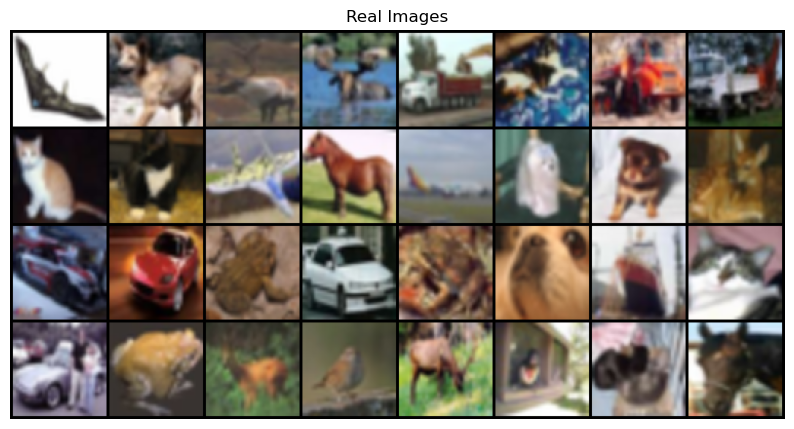

In [8]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [9]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
           
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            
            self.Dnet(features_d, features_d * 2, 4, 2, 1),      #out=128,k=5,s=2,p=1
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  #out=256,k=5,s=2,p=1
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  #out=512,k=5,s=2,p=1
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            
            nn.Sigmoid(),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            #nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


In [10]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            #Gnet(in_channels, out_channels, kernel_size, stride, padding)
            self.Gnet(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [11]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [12]:
#Intitating instances
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)
optimGenerator = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(beta, 0.999))
optimDiscriminator = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(beta, 0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)   
step = 0

In [13]:
gen.train(),disc.train()

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): C

In [14]:
class InceptionV3(nn.Module):
  

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

In [15]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [16]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
  

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [17]:
def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
    """get fretched distance"""
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [18]:
#training block
GenLoss = []
DiscLoss = []
img_list = []
FID_list = []
iters = 0
print("In the training block")
#start timing
time_start = time.time() 
for epoch in range(NUM_EPOCHS):
    epoch = epoch+1
    
#     for batch_idx, (real, _) in enumerate(dataloader):

    for batch_idx, data in enumerate(dataloader,0):
        #training with real batch
        real = data[0].to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise) #genrator img data

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        optimDiscriminator.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())
        
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    
    #Cal. FID
    fretchet_dist=calculate_fretchet(real,fake,model)
    FID_list.append(fretchet_dist)
    
    if epoch%3 == 0:
        print( f'\nEpoch {epoch}/{NUM_EPOCHS} Discriminator_Loss: {loss_disc:.3f},Generator_Loss: {loss_gen:.3f} FID:{fretchet_dist:.3f}')
    #Saving Generated image/epoch     
    images = gen(fixed_noise)
    if not os.path.exists('Results/DCGAN_FAKE'):
       os.makedirs('Results/DCGAN_FAKE')
    if not os.path.exists('Results/DCGAN_REAL'):
       os.makedirs('Results/DCGAN_REAL')
    utils.save_image(images.detach(),'Results/DCGAN_FAKE/DCGAN50_epoch_%03d.png' % (epoch), normalize = True)
    
    #Saving Real image/epoch 
#     real = data[0].to(device)
    utils.save_image(real.detach(),'Results/DCGAN_REAL/DCGAN50_epoch_%03d.png' % (epoch), normalize = True)
        
    
time_end = time.time()
print('\n\n elapsed time：%.2f s.'%(time_end-time_start))

In the training block

Epoch 3/15 Discriminator_Loss: 0.815,Generator_Loss: 1.236 FID:325.510

Epoch 6/15 Discriminator_Loss: 0.610,Generator_Loss: 1.077 FID:267.315

Epoch 9/15 Discriminator_Loss: 0.525,Generator_Loss: 1.084 FID:283.814

Epoch 12/15 Discriminator_Loss: 0.452,Generator_Loss: 1.202 FID:260.472

Epoch 15/15 Discriminator_Loss: 0.567,Generator_Loss: 1.251 FID:280.569


 elapsed time：1284.95 s.


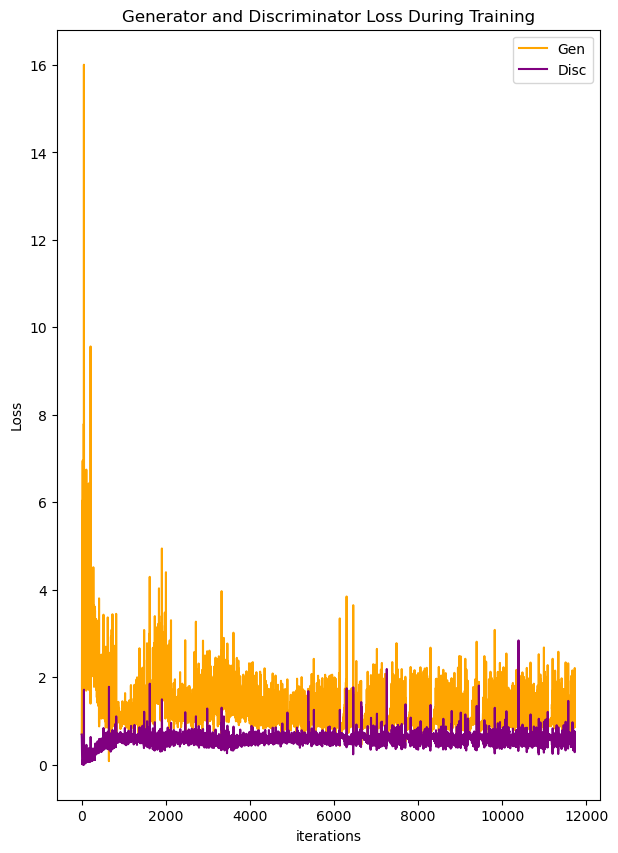

In [19]:
if not os.path.exists('Results/Loss_Data'):
       os.makedirs('Results/Loss_Data')
np.save('Results/Loss_Data/DCGAN_GLoss', GenLoss) 
np.save('Results/Loss_Data/DCGAN_DLoss', DiscLoss) 
GenLoss = np.load('Results/Loss_Data/DCGAN_GLoss.npy')
DiscLoss = np.load('Results/Loss_Data/DCGAN_DLoss.npy')
plt.figure(figsize=(7,10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Gen",color="Orange")
plt.plot(DiscLoss,label="Disc",color="purple")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Results/loss.pdf',
            format='pdf',
            bbox_inches='tight')
plt.show()

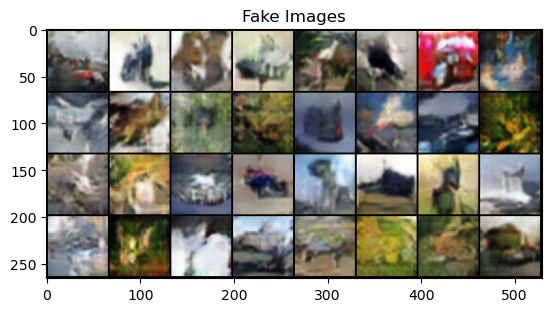

In [20]:

real_batch = next(iter(dataloader))

# Plot the real images
#plt.figure(figsize=(15,15))
#plt.subplot(1,2,1)
#plt.axis("off")
#plt.title("Real Images")
#plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))
#plt.subplot(1,2,2)
#plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('Results/DCGAN30_BEST_FAKE_32.pdf',
            format='pdf',
            bbox_inches='tight')
plt.show()

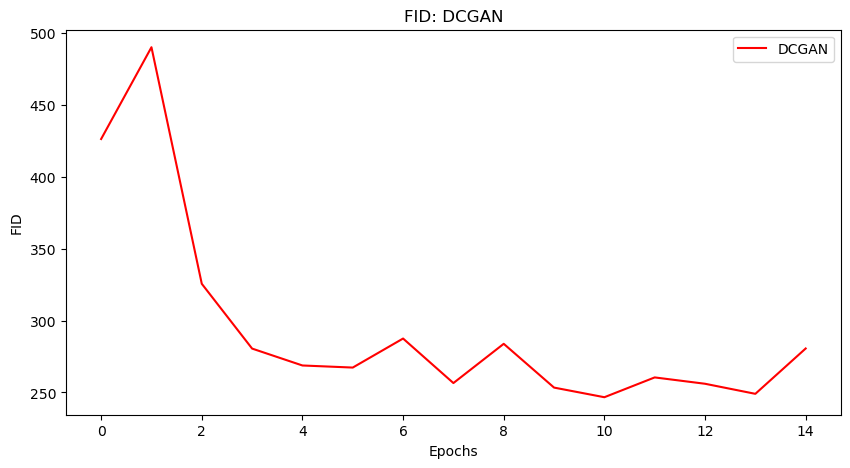

In [21]:
plt.figure(figsize=(10,5))
plt.title("FID: DCGAN")
plt.plot(FID_list,label="DCGAN",color="red")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('Results/FID.pdf',
            format='pdf',
            bbox_inches='tight')
plt.show()